In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [ ]:
df = pd.read_csv('ITO_2years.csv')
df = df[:10000]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['values_normalized'] = scaler.fit_transform(df[['value']])

In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 10
X = create_sequences(df['values_normalized'].values, seq_length)


In [ ]:
split_percentage = 0.8
split_index = int(split_percentage * len(X))

X_train, X_test = X[:split_index], X[split_index:]

y_train = df['values_normalized'][seq_length:split_index].values
y_train = torch.Tensor(y_train)
y_train = y_train.view(-1, 1)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20

for epoch in range(epochs):
    epoch_loss = 0.0  # Initialize epoch_loss for each epoch
    for seq, label in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(torch.Tensor(seq))
        single_loss = loss_function(y_pred, torch.Tensor([label]))
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()

    # Display loss after each epoch
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(X_train)}')

Epoch [1/20], Loss: 0.0011031644626954763
Epoch [2/20], Loss: 0.0003165395022477592
Epoch [3/20], Loss: 0.00025162522232594374
Epoch [4/20], Loss: 0.00023679357100429746
Epoch [5/20], Loss: 0.00022745968158664927
Epoch [6/20], Loss: 0.00024145813913128606
Epoch [7/20], Loss: 0.00022195012200848987
Epoch [8/20], Loss: 0.0002219026103750592
Epoch [9/20], Loss: 0.00022002115939722246
Epoch [10/20], Loss: 0.00020787524516911247
Epoch [11/20], Loss: 0.00020935047490675682
Epoch [12/20], Loss: 0.00020707354437014117
Epoch [13/20], Loss: 0.00020608834904844515
Epoch [14/20], Loss: 0.00020000322262566793
Epoch [15/20], Loss: 0.00019207357390385203
Epoch [16/20], Loss: 0.00019957560094396848
Epoch [17/20], Loss: 0.00019412081434765186
Epoch [18/20], Loss: 0.00019169684877804743
Epoch [19/20], Loss: 0.0001895683039916655
Epoch [20/20], Loss: 0.00019455474787767897


In [38]:
test_inputs = torch.Tensor(X_test)
predictions = []

for i in range(len(X_test)):
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(test_inputs[i]).item())

predicted_pm25 = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
predicted_pm25

array([[24.03291112],
       [24.33864104],
       [25.52342305],
       ...,
       [52.69601645],
       [41.05990922],
       [27.905993  ]])

In [40]:
mse = np.mean(np.square(df['value'][split_index + seq_length:] - predicted_pm25.flatten()))
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 350.11142740103384


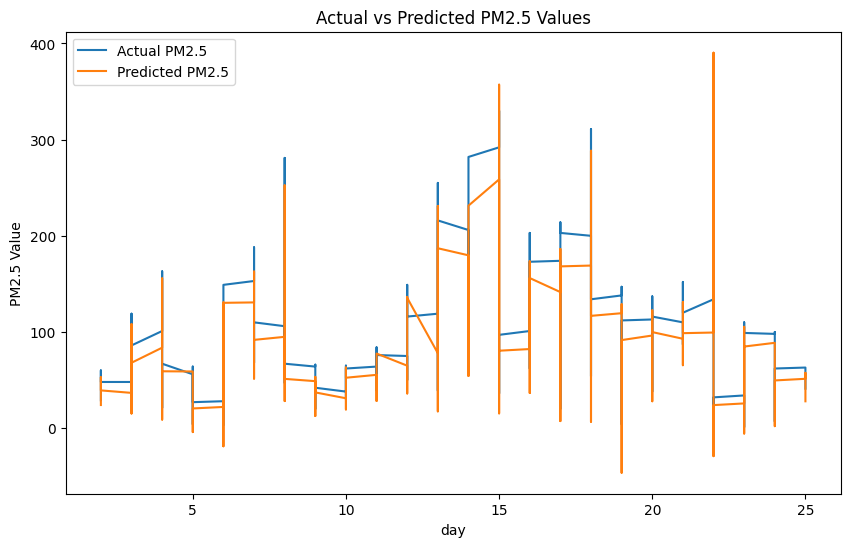

In [44]:
actual_pm25 = df['value'][split_index + seq_length:].values

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['day'][split_index + seq_length:], actual_pm25, label='Actual PM2.5')
plt.plot(df['day'][split_index + seq_length:], predicted_pm25, label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5 Values')
plt.xlabel('day')
plt.ylabel('PM2.5 Value')
plt.legend()
plt.show()